In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from PIL import Image

import lightning as L
from torch.utils.data import random_split, Dataset, DataLoader

# Create train.csv and test.csv

In [3]:
res = []
for file in os.listdir("./BrainTumorDataset/test/imagesTest"):
    # print(file)
    res.append(file)
res = sorted(res)[2:]
res

df1 = pd.DataFrame(res)
df2 = pd.DataFrame(np.repeat(df1.values, 151, axis=0))
df2.to_csv('list_test.csv')

In [4]:
base = []
for path, subdirs, files, in os.walk("./BrainTumorDataset/test/imagesTest"):
    for name in files:
        base.append(os.path.join(path, name))
base = sorted(base)[2:]
# base

df = pd.DataFrame(base)
df.to_csv("test_image_list")

In [9]:
base

['./BrainTumorDataset/test/imagesTest/BRATS_001/._BRATS_001_x1_z036.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z001.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z002.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z003.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z004.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z005.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z006.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z007.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z008.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z009.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z010.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z011.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z012.png',
 './BrainTumorDataset/test/imagesTest/BRATS_001/BRATS_001_x1_z

In [5]:
x1_filter = [name for name in base if 'x1' in name]
x2_filter = [name for name in base if 'x2' in name]
x3_filter = [name for name in base if 'x3' in name]
x4_filter = [name for name in base if 'x4' in name]

In [15]:
x1_filter = x1_filter[1:]
len(x1_filter)

15035

In [11]:
len(x2_filter)

15035

In [12]:
len(x3_filter)

15035

In [13]:
len(x4_filter)

15035

In [6]:
base_mask  = []
for path, subdirs, files, in os.walk("./BrainTumorDataset/test/labelsTest"):
    for name in files:
        base_mask.append(os.path.join(path, name))
base_mask = sorted(base_mask)[2:]
base_mask

['./BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z001.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z002.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z003.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z004.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z005.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z006.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z007.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z008.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z009.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z010.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z011.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z012.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z013.png',
 './BrainTumorDataset/test/labelsTest/BRATS_001/BRATS_001_z014.png',
 './BrainTumorDataset/test/labelsT

In [16]:
test_df = pd.DataFrame({
    'mode_0': x1_filter,
    'mode_1': x2_filter,
    'mode_2': x3_filter,
    'mode_3': x4_filter,
    'mask': base_mask
})
test_df.to_csv("test.csv")

# Further down

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_0 = np.array(Image.open(self.csv.loc[idx]["mode_0"]).convert("L"), dtype=np.float32)
        image_1 = np.array(Image.open(self.csv.loc[idx]["mode_1"]).convert("L"), dtype=np.float32)
        image_2 = np.array(Image.open(self.csv.loc[idx]["mode_2"]).convert("L"), dtype=np.float32)
        image_3 = np.array(Image.open(self.csv.loc[idx]["mode_3"]).convert("L"), dtype=np.float32)
        
        image = np.stack((image_0, image_1, image_2, image_3), axis=2)
        mask = np.array(Image.open(self.csv.loc[idx]["mask"]).convert("L"), dtype=np.float32)

        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Non-Lightning code

In [10]:
train_dataset = BrainTumorDataset(csv_file="train.csv")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [13]:
train_dataset[100][1].shape

(240, 240)

In [16]:
train_dataset[100][1].min()
train_dataset[100][1].max()


3.0

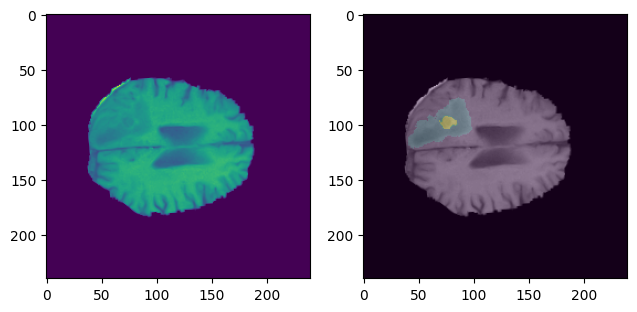

In [12]:
_, figure = plt.subplots(1, 2, figsize=(7.5, 15))

figure[0].imshow(train_dataset[100][0][:,:,1])
figure[1].imshow(train_dataset[100][0][:,:,1], 'gray', interpolation=None)
figure[1].imshow(train_dataset[100][1], interpolation=None, alpha=0.3)
plt.show()

# Lightning code

In [3]:
class BrainTumorDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        pass

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            full = BrainTumorDataset(csv_file="train.csv")
            self.train, self.val = random_split(
                full, [0.9, 0.1], generator=torch.Generator().manual_seed(42)
            )

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.test = BrainTumorDataset(csv_file="test.csv")

        # if stage == "predict":
        #     self.mnist_predict = BrainTumorDataset(csv_file="train.csv")

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32, num_workers=11)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=32, num_workers=11)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=32, num_workers=11)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=32)
    

## FCN with CrossEntropyLoss

In [19]:
import torchvision
from torchvision.models.segmentation import fcn_resnet50
from torchmetrics.segmentation import GeneralizedDiceScore
from torchmetrics.classification import MulticlassAccuracy

model = fcn_resnet50(num_classes=4)

class LitFCN(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()

        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)

        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        softmax = torch.nn.Softmax(dim=1)
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch

        # implement your own
        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()

        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)

        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        softmax = torch.nn.Softmax(dim=1)
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch

        # implement your own
        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()

        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)

        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        softmax = torch.nn.Softmax(dim=1)
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

## FCN with DiceLoss

In [138]:
import torchvision
from torchvision.models.segmentation import fcn_resnet50
from torchmetrics.segmentation import GeneralizedDiceScore
from torchmetrics.classification import MulticlassAccuracy
from monai.losses.dice import DiceLoss

model = fcn_resnet50(num_classes=4)

class LitFCN(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()
        softmax = torch.nn.Softmax(dim=1)
        # output = torch.unsqueeze(torch.argmax(softmax(y_hat),axis=1), 1)
        loss_fn = DiceLoss(include_background=False, softmax=True, to_onehot_y=True)

        
        loss = loss_fn(y_hat, torch.unsqueeze(y, 1))
        
        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()
        softmax = torch.nn.Softmax(dim=1)
        # output = torch.unsqueeze(torch.argmax(softmax(y_hat),axis=1), 1)
        loss_fn = DiceLoss(include_background=False, softmax=True, to_onehot_y=True)

        
        loss = loss_fn(y_hat, torch.unsqueeze(y, 1))
        
        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        y = y.long()
        softmax = torch.nn.Softmax(dim=1)
        # output = torch.unsqueeze(torch.argmax(softmax(y_hat),axis=1), 1)
        loss_fn = DiceLoss(include_background=False, softmax=True, to_onehot_y=True)

        
        loss = loss_fn(y_hat, torch.unsqueeze(y, 1))
        
        metric = MulticlassAccuracy(num_classes=4).to(device='cuda')
        mca = MulticlassAccuracy(num_classes=4, average=None).to(device="cuda")
        gds_fn = GeneralizedDiceScore(num_classes=4).to(device='cuda')
        
        preds = torch.argmax(softmax(y_hat),axis=1)
        gds = gds_fn(preds, y)
        acc = metric(preds, y)
        acc_by_class = mca(preds, y)
        self.log_dict({"loss": loss, "GDS": gds, "Accuracy": acc, "Accuracy_0": acc_by_class[0], "Accuracy_1": acc_by_class[1], "Accuracy_2": acc_by_class[2], "Accuracy_3": acc_by_class[3]}, prog_bar=True)
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4, amsgrad=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

In [139]:
model.backbone.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [140]:
dm = BrainTumorDataModule()

In [141]:
trainer = L.Trainer(max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [142]:
mod = LitFCN(model)
trainer.fit(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 33.0 M
-------------------------------
33.0 M    Trainable params
0         Non-trainable params
33.0 M    Total params
131.806   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Results

### FCN with CrossEntropyLoss

In [26]:
trainer.validate(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.8092448711395264     │
│        Accuracy_0         │    0.9991514682769775     │
│        Accuracy_1         │    0.8200201392173767     │
│        Accuracy_2         │    0.6039202809333801     │
│        Accuracy_3         │    0.8138877749443054     │
│            GDS            │    0.2642412483692169     │
│           loss            │   0.008773406967520714    │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.008773406967520714,
  'GDS': 0.2642412483692169,
  'Accuracy': 0.8092448711395264,
  'Accuracy_0': 0.9991514682769775,
  'Accuracy_1': 0.8200201392173767,
  'Accuracy_2': 0.6039202809333801,
  'Accuracy_3': 0.8138877749443054}]

In [27]:
trainer.test(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.7441270351409912     │
│        Accuracy_0         │    0.9989368915557861     │
│        Accuracy_1         │    0.4118005335330963     │
│        Accuracy_2         │    0.15719811618328094    │
│        Accuracy_3         │    0.3003227412700653     │
│            GDS            │    0.25377392768859863    │
│           loss            │   0.012154382653534412    │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.012154382653534412,
  'GDS': 0.25377392768859863,
  'Accuracy': 0.7441270351409912,
  'Accuracy_0': 0.9989368915557861,
  'Accuracy_1': 0.4118005335330963,
  'Accuracy_2': 0.15719811618328094,
  'Accuracy_3': 0.3003227412700653}]

### FCN with DiceLoss

In [126]:
trainer.validate(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.7393619418144226     │
│        Accuracy_0         │    0.6726481318473816     │
│        Accuracy_1         │    0.8179411292076111     │
│        Accuracy_2         │    0.6636540293693542     │
│        Accuracy_3         │    0.8032048344612122     │
│            GDS            │    0.26401859521865845    │
│           loss            │    0.7851587533950806     │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.7851587533950806,
  'GDS': 0.26401859521865845,
  'Accuracy': 0.7393619418144226,
  'Accuracy_0': 0.6726481318473816,
  'Accuracy_1': 0.8179411292076111,
  'Accuracy_2': 0.6636540293693542,
  'Accuracy_3': 0.8032048344612122}]

In [127]:
trainer.test(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.42408454418182373    │
│        Accuracy_0         │     0.668651282787323     │
│        Accuracy_1         │    0.45856988430023193    │
│        Accuracy_2         │    0.2319984883069992     │
│        Accuracy_3         │    0.32477062940597534    │
│            GDS            │    0.2607285678386688     │
│           loss            │    0.7976341843605042     │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.7976341843605042,
  'GDS': 0.2607285678386688,
  'Accuracy': 0.42408454418182373,
  'Accuracy_0': 0.668651282787323,
  'Accuracy_1': 0.45856988430023193,
  'Accuracy_2': 0.2319984883069992,
  'Accuracy_3': 0.32477062940597534}]

### FCN with Dice with amsgrad

In [143]:
trainer.validate(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.7302005887031555     │
│        Accuracy_0         │    0.6424749493598938     │
│        Accuracy_1         │    0.8129366040229797     │
│        Accuracy_2         │    0.6642823219299316     │
│        Accuracy_3         │    0.8011086583137512     │
│            GDS            │    0.2645774781703949     │
│           loss            │    0.7860442399978638     │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.7860442399978638,
  'GDS': 0.2645774781703949,
  'Accuracy': 0.7302005887031555,
  'Accuracy_0': 0.6424749493598938,
  'Accuracy_1': 0.8129366040229797,
  'Accuracy_2': 0.6642823219299316,
  'Accuracy_3': 0.8011086583137512}]

In [144]:
trainer.test(mod, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.41698935627937317    │
│        Accuracy_0         │    0.6414263844490051     │
│        Accuracy_1         │    0.4527345299720764     │
│        Accuracy_2         │    0.2378026694059372     │
│        Accuracy_3         │    0.32582157850265503    │
│            GDS            │    0.2639075219631195     │
│           loss            │    0.7972618937492371     │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.7972618937492371,
  'GDS': 0.2639075219631195,
  'Accuracy': 0.41698935627937317,
  'Accuracy_0': 0.6414263844490051,
  'Accuracy_1': 0.4527345299720764,
  'Accuracy_2': 0.2378026694059372,
  'Accuracy_3': 0.32582157850265503}]